In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import sys
import random
from torchvision import transforms  
import torch.nn as nn
import torch.nn.functional as F

In [26]:
tumor = []
healthy = []
for f in glob.iglob("./data/Brain_Tumor_Dataset/Positive/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/Brain_Tumor_Dataset/Negative/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [27]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [28]:
tumor.shape

(3266, 128, 128, 3)

In [29]:
healthy.shape

(2000, 128, 128, 3)

In [30]:
np.random.choice(10, 5, replace=False)

array([5, 4, 0, 6, 7])

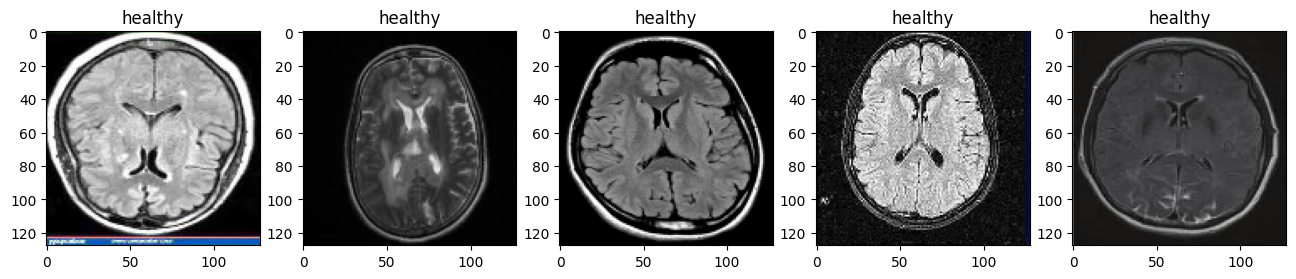

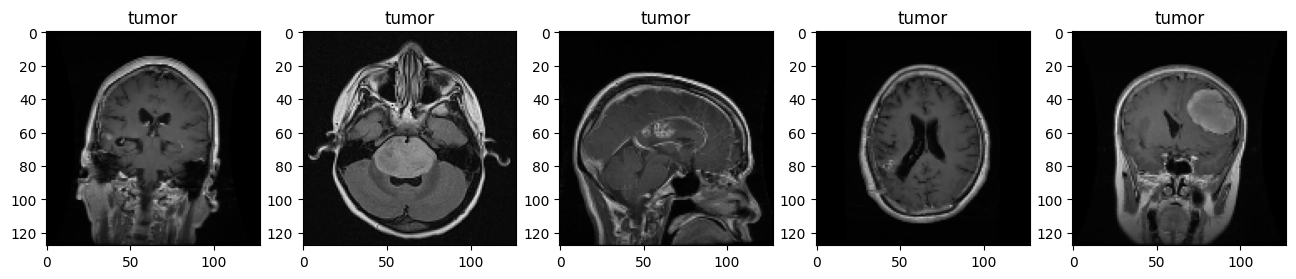

In [31]:
#Visualise MRI images
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

plot_random(healthy, tumor, num=5)

In [32]:
#Torch Dataset Class
class Dataset(object):

    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, index):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [33]:
#Define MRI custom dataset class
class MRIDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.tumor = []
        self.healthy = []
        
        #Load tumor images
        for f in glob.iglob(f"{data_path}/Positive/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.tumor.append(img)

        #Load healthy images
        for f in glob.iglob(f"{data_path}/Negative/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.healthy.append(img)
        
    def __len__(self):
        return len(self.tumor) + len(self.healthy)
    
    def __getitem__(self, index):
        if index < len(self.tumor):
            img = self.tumor[index]
            label = 1  #Tumor
        else:
            img = self.healthy[index - len(self.tumor)]
            label = 0  #Healthy
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

#Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [34]:
#Data loader
data_path = "./data/Brain_Tumor_Dataset"
dataset = MRIDataset(data_path, transform=transform)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [35]:
#CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [36]:
#ToDo: Evaluate model 